In [1]:
import itertools
import random
from collections import Counter
import joblib
import pickle
import pandas as pd
import numpy as np
import re
from keras import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Bidirectional, LSTM
from keras.utils.np_utils import to_categorical
from nltk.corpus import stopwords
from parsivar import Normalizer
import emoji
import emojies
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

In [2]:
class CleanText:
    def __init__(self, data_frame, column_name):
        self.cln_list = data_frame[column_name].tolist()
    def __new__(cls, data_frame, column_name,*args, **kwargs):
        data_frame[column_name] = data_frame[column_name].apply(lambda x: x[:400])
        return super().__new__(cls,*args, **kwargs)
    def clean_punctual(self):
        tmp_lst = list(map(lambda x: re.sub(r'https?:\S*', ' ', x), self.cln_list))
        tmp_lst = list(map(lambda x: re.sub(r'@[A-Za-z0-9]\S+', ' ', x), tmp_lst))
        tmp_lst = list(map(lambda x: re.sub(r'[0-9]\S+', ' ', x), tmp_lst))
        self.cln_list = list(map(lambda x: re.sub(r'#|_|:|/d+', ' ', x), tmp_lst))
        return self.cln_list
    def normalize_text(self):
        normalizer = Normalizer(pinglish_conversion_needed=True)
        cln_list = list(map(lambda x: normalizer.normalize(x), self.cln_list))
        self.cln_list = list(map(lambda x: ''.join(ch for ch, _ in itertools.groupby(x)), cln_list))
        return self.cln_list
    def remove_stop_words(self):
        stop_words = set(stopwords.words('RD_persian_01'))
        self.cln_list = list(map(lambda x: ' '.join([w for w in x.split() if not w in stop_words]), self.cln_list))
        return self.cln_list
    def extract_emojis(self):
        self.cln_list = list(map(lambda x: ''.join((' '+c+' ') if c in emoji.UNICODE_EMOJI['en'] else c for c in x), self.cln_list))
        return self.cln_list
    def convert_emojies(self):
        self.cln_list = list(map(lambda x: emojies.replace(x), self.cln_list))
        return self.cln_list
    def frequency_words(self):
        freq = dict(Counter(" ".join(self.cln_list).split()))
        sort_orders = sorted(freq.items(), key=lambda x: x[1], reverse=True)
        sort_orders = sort_orders[:4000]
        # print(sort_orders)
        print(len(sort_orders))
        most_common_word = [i[0] for i in sort_orders]
        most_common_word = set(most_common_word)
        # print(most_common_word)
        print(len(most_common_word))
        self.cln_list = list(map(lambda x: ' '.join([w for w in x.split() if w in most_common_word]), self.cln_list))
        return self.cln_list


In [3]:
class EncodeText:
    def __init__(self,train_text):
        self.train_text = train_text
    def create_tokenizer(self):
        tokenizer = Tokenizer()
        tokenizer.fit_on_texts(self.train_text)
        return tokenizer
    def encode_text(self,tokenizer, input_list, max_length):
        # integer encode
        encoded = tokenizer.texts_to_sequences(input_list)
        # pad encoded sequences
        padded = pad_sequences(encoded, maxlen=max_length, padding='post')
        return padded
    def label_encoder(self, tag):
        le = LabelEncoder()
        tmp_tag = le.fit_transform(tag)
        encode_tag = to_categorical(np.array(tmp_tag))
        return encode_tag

In [4]:
# data_df = pd.read_excel('dataset.2.0.0.xlsx', index_col= False)
# fig, ax = plt.subplots()
# ax.hist(data_df['احساس'])
# plt.show()

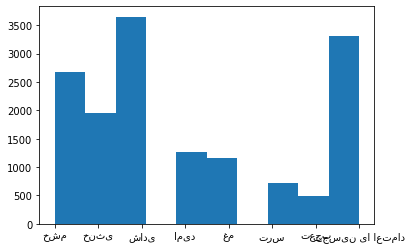

In [5]:
data_df = pd.read_csv('comp_dataset2.csv', index_col= False)
fig, ax = plt.subplots()
ax.hist(data_df['tag'])
plt.show()

In [6]:
# call_cleantext = CleanText(data_df, 'متن توییت')
# call_cleantext = CleanText(data_df, 'Text')
call_cleantext = CleanText(data_df, 'caption')
get_pun_list = call_cleantext.clean_punctual()
print(get_pun_list[64])
get_ex_emoji = call_cleantext.extract_emojis()
print(get_ex_emoji[64])
get_emoji_list = call_cleantext.convert_emojies()
print(get_emoji_list[64])
get_norm_list = call_cleantext.normalize_text()
print(get_norm_list[64])
get_rm_sw_list = call_cleantext.remove_stop_words()
print(get_rm_sw_list[64])
get_most_com_list = call_cleantext.frequency_words()
print(get_most_com_list[64])

همسر من تو سکو نفتی کار می کنه ماموریت طولانی مدت می ره همه کارا رو دوش منه الان که مهد کودک تعطیل شده زندگی مثل جهنم شده
همسر من تو سکو نفتی کار می کنه ماموریت طولانی مدت می ره همه کارا رو دوش منه الان که مهد کودک تعطیل شده زندگی مثل جهنم شده
همسر من تو سکو نفتی کار می کنه ماموریت طولانی مدت می ره همه کارا رو دوش منه الان که مهد کودک تعطیل شده زندگی مثل جهنم شده
همسر من تو سکو نفتی کار می‌کنه ماموریت طولانی مدت می‌ره همه کارا رو دوش منه الان که مهد کودک تعطیل‌شده‌زندگی مثل جهنم شده
همسر سکو نفتی می‌کنه ماموریت طولانی مدت می‌ره کارا منه الان مهد کودک تعطیل‌شده‌زندگی جهنم شده
4000
4000
همسر می‌کنه طولانی مدت کارا منه الان کودک جهنم شده


In [7]:
get_most_com_list = call_cleantext.frequency_words()

4000
4000


In [8]:
# init_List_prepared = list(map(lambda x: [x[0], x[1]], zip(get_most_com_list, data_df['احساس'])))
init_List_prepared = list(map(lambda x: [x[0], x[1]], zip(get_most_com_list, data_df['tag'])))
init_List_prepared = list(filter(lambda x: len(x[0])>1, init_List_prepared))
random.shuffle(init_List_prepared)

var1 = list(filter(lambda x: x[1]=='شادی', init_List_prepared))
var2 = list(filter(lambda x: x[1]=='خشم', init_List_prepared))
var3 = list(filter(lambda x: x[1]=='غم', init_List_prepared))
var4 = list(filter(lambda x: x[1]=='خنثی', init_List_prepared))
var5 = list(filter(lambda x: x[1]=='امید', init_List_prepared))
var6 = list(filter(lambda x: x[1]=='ترس', init_List_prepared))
var7 = list(filter(lambda x: x[1]=='تعجب', init_List_prepared))
var8 = list(filter(lambda x: x[1]=='تحسین یا اعتماد', init_List_prepared))

# List_prepared = var1[:1500]+var2[:1500]+var3[:1000]+var4[:1000]+var5[:1200]+var6[:700]+var7[:500]+var8[:1500]
# List_prepared = var1[:500]+var2[:500]+var3[:500]+var4[:500]+var5[:500]+var6[:500]+var7[:500]+var8[:500]
# List_prepared = var1[:2700]+var2[:2700]
# List_prepared = var1+var2+var5+var8
List_prepared = var1+var2+var3+var5

# List_prepared = init_List_prepared

In [9]:
text, tag = zip(*List_prepared)
train_text, test_text, train_tag, test_tag = train_test_split(text, tag, test_size=0.2)

In [10]:
call_encodetext = EncodeText(train_text)
tokenizer = call_encodetext.create_tokenizer()
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)
max_len = 100
encode_train_text = call_encodetext.encode_text(tokenizer, train_text, max_len)
encode_test_text = call_encodetext.encode_text(tokenizer, test_text, max_len)
encode_train_tag = call_encodetext.label_encoder(train_tag)
encode_test_tag = call_encodetext.label_encoder(test_tag)
num_cat = encode_train_tag.shape[1]

3731


In [11]:
# single Bidir layer
model = Sequential()
model.add(Embedding(vocab_size, 50, input_length=max_len))
model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.3)))
# model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.3)))
model.add(Dense(num_cat, activation='softmax'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 50)           186550    
                                                                 
 bidirectional (Bidirectiona  (None, 200)              120800    
 l)                                                              
                                                                 
 dense (Dense)               (None, 4)                 804       
                                                                 
Total params: 308,154
Trainable params: 308,154
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fitting Network
m = model.fit(encode_train_text, encode_train_tag, epochs=100, verbose=2)
# Evaluating Network
loss, acc = model.evaluate(encode_test_text, encode_test_tag, verbose=0)
print('Test Accuracy: %f' % (acc * 100))
print('Test loss: %f' % loss)
# !khashm, khonsa, shadi, gham of 1e4 51%

Epoch 1/100
209/209 - 29s - loss: 1.0318 - accuracy: 0.5677 - 29s/epoch - 138ms/step
Epoch 2/100
209/209 - 25s - loss: 0.6348 - accuracy: 0.7640 - 25s/epoch - 119ms/step
Epoch 3/100
209/209 - 25s - loss: 0.4480 - accuracy: 0.8377 - 25s/epoch - 119ms/step
Epoch 4/100
209/209 - 25s - loss: 0.3426 - accuracy: 0.8818 - 25s/epoch - 119ms/step
Epoch 5/100
209/209 - 25s - loss: 0.2769 - accuracy: 0.9020 - 25s/epoch - 119ms/step
Epoch 6/100
209/209 - 25s - loss: 0.2295 - accuracy: 0.9219 - 25s/epoch - 119ms/step
Epoch 7/100
209/209 - 25s - loss: 0.2120 - accuracy: 0.9278 - 25s/epoch - 120ms/step
Epoch 8/100
209/209 - 25s - loss: 0.1759 - accuracy: 0.9428 - 25s/epoch - 119ms/step
Epoch 9/100
209/209 - 25s - loss: 0.1582 - accuracy: 0.9462 - 25s/epoch - 120ms/step
Epoch 10/100
209/209 - 26s - loss: 0.1491 - accuracy: 0.9513 - 26s/epoch - 124ms/step
Epoch 11/100
209/209 - 26s - loss: 0.1412 - accuracy: 0.9520 - 26s/epoch - 123ms/step
Epoch 12/100
209/209 - 25s - loss: 0.1275 - accuracy: 0.9585 - 

In [13]:
with open('BiLSTM_3_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# # # loading
# # with open('BiLSTM_3_tokenizer.pickle', 'rb') as handle:
# #     tokenizer = pickle.load(handle)
joblib.dump(model, 'BiLSTM_3_model.joblib')


INFO:tensorflow:Assets written to: ram://7301ea02-e95e-4f5a-9f87-9e3c50b42168/assets


['BiLSTM_3_model.joblib']

In [14]:
# test_df = pd.DataFrame()
# test_df['train_text'] = train_text
# test_df['tag_text'] = train_tag
# test_df['encode_train_tag'] = encode_train_tag.tolist()
# test_df.to_excel('test2_df.xlsx', index=False)

In [15]:
# tmp_df = pd.DataFrame()
# comment = train_text
# tmp_df['tmp_caption']=comment
# print(tmp_df)
# tmp_call_cleantext = CleanText(tmp_df, 'tmp_caption')
# tmp_get_ex_emoji = tmp_call_cleantext.extract_emojis()
# print(tmp_get_ex_emoji)
# tmp_get_emoji_list = tmp_call_cleantext.convert_emojies()
# tmp_get_norm_list = tmp_call_cleantext.normalize_text()
# print(tmp_get_norm_list)
#
# list_a = []
# i = 0
# for item in tmp_get_norm_list:
#     i += 1
#     # print(i)
#     comment_list = item
#     instance = tokenizer.texts_to_sequences(comment_list)
#     flat_list = []
#     for sublist in instance:
#         for item in sublist:
#             flat_list.append(item)
#
#     flat_list = [flat_list]
#
#     instance = pad_sequences(flat_list, padding='post', maxlen=max_len)
#
#     output = model.predict(instance)
#     list_a.append(output)
# # print(list_a)
# train_df = pd.DataFrame()
# train_df['train_text'] = train_text
# train_df['tag_text'] = train_tag
# train_df['encode_train_tag'] = encode_train_tag.tolist()
# train_df['my_model'] = list_a
# train_df.to_excel('train2_df.xlsx', index=False)

In [16]:
# df = pd.read_excel('train2_df.xlsx')
# list_b = df['my_model']
# list_c = list(map(lambda x: list(x[2:-2].split(" ")), list_b))
# list_c = list(map(lambda x: list(filter(None, x)), list_c))
#
# list_d = list(map(lambda x: [re.sub('\n','', i) for i in x], list_c))
#
# list_e = list(map(lambda x: [float(i) for i in x], list_d))
# list_f = list(map(lambda x: x.index(max(x)), list_e))
# train_df['my_model2'] = list_f
# train_df.to_excel('train2_df.xlsx', index=False)
